<a href="https://colab.research.google.com/github/charlesmartin14/theory-paper/blob/main/notebooks/LSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Applying WeightWatcher to a simple LSA (Latent Semantic Analysis) Calculation

We:

- download and vectorize the 20Newsgroups dataset (just using a CountVectorizer)

- run SVD on the data matrix, keeping the top 5000 components

- apply the weightwatcher powerlaw method, and find $\alpha$ and $x_{min}=\lambda_{min}$

- Compare $\lambda_{min}$ to the explained variance, and 

- the Trace Log Norm $\det\mathbf{X}^{eff}=1$ condition


#### TODO:  redo and triple check detX calcs

In [1]:

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
pd.set_option("display.max_colwidth", 200)

In [2]:
from google.colab import drive
drive.mount('/drive')
results_dir = '/drive/MyDrive/setol_paper'

!ls $results_dir
save = True

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
alpha_vs_testacc.png  LSA_variance.png	    model_bs16	   model_bs8
bs_vs_testacc.png     MLP3_bs16_FC2.png     model_bs16.h5  model_bs8.h5
bs_vs_trainacc.png    MLP3_bs1_FC2.png	    model_bs1.h5   svd20_vs_testacc.png
LSA_detX.png	      MLP3_bs2_FC2.png	    model_bs2	   svd50_vs_testacc.png
LSA_D_KS.png	      MLP3_bs32_FC2.png     model_bs2.h5   svdP_vs_testacc.png
LSA_evals.png	      MLP3_bs4_FC2.png	    model_bs32	   VIT.png
LSA_local_ratios.png  MLP3_bs8_FC2.png	    model_bs32.h5  VIT_TPL.png
LSA_log_lin_ESD.png   mlp3_results.feather  model_bs4
LSA_PL_fit.png	      model_bs1		    model_bs4.h5


In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 16
LARGE_SIZE =30

plt.rc('font', size=LARGE_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title

In [4]:
from pickle import FALSE
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

data, _ = fetch_20newsgroups(
    shuffle=False,
    random_state=1,
    remove=("headers", "footers", "quotes"),
    return_X_y=True,
)


# Use tf-idf features for NMF.
print("Extracting tf-idf features ...")
tfidf_vectorizer = TfidfVectorizer(
   max_df=0.95, min_df=2, max_features=20000, stop_words="english"
)

X  = tfidf_vectorizer.fit_transform(data)
X.shape


Extracting tf-idf features ...


(11314, 20000)

In [5]:
#from sklearn.datasets import fetch_20newsgroups_vectorized
#X, y = fetch_20newsgroups_vectorized(subset='all', return_X_y=True)
#print(X.shape)

### see:
 https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

In [6]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=5000)
svd_model.fit(X)
sv = svd_model.singular_values_
evals = sv*sv


In [7]:
pip install powerlaw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import powerlaw

fit = powerlaw.Fit(evals)
fit.alpha, fit.xmin

Calculating best minimal value for power law fit


(3.539166372586978, 5.766786371789856)

### Nunmber of eigenvalues in the fitted PL  tail

In [9]:
start_idx = len(evals[evals >= fit.xmin])
start_idx

240

### WeightWatcher Log-Lin and KS Plots

saving /drive/MyDrive/setol_paper/LSA_log_lin_ESD.png


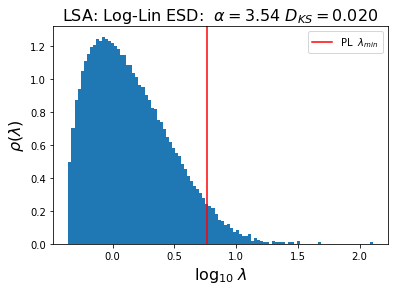

In [10]:
plt.hist(np.log10(evals[evals>0.001]),bins=100, density=True);
plt.axvline(x=np.log10(fit.xmin), color='red', label=r"PL  $\lambda_{min}$")
title =  "LSA: Log-Lin ESD:  "+r"$\alpha=$"+"{:0.2f}".format(fit.alpha) + r" $D_{KS}=$"+"{:0.3f}".format(fit.D)
plt.title(title)
plt.xlabel(r"$\log_{10}\;\lambda$")
plt.ylabel(r"$\rho(\lambda)$")
plt.legend()
if save:
  filename = "LSA_log_lin_ESD.png"
  filename = f"{results_dir}/{filename}"
  print(f"saving {filename}")
  plt.savefig(filename)
plt.show()


saving /drive/MyDrive/setol_paper/LSA_D_KS.png


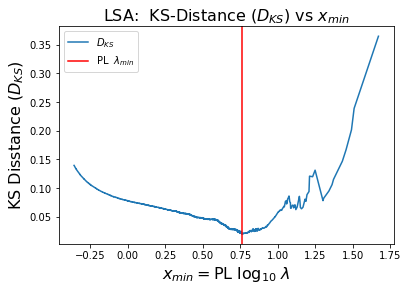

In [11]:
plt.plot(np.log10(fit.xmins), fit.Ds, label=r'$D_{KS}$')
plt.axvline(x=np.log10(fit.xmin), color='red', label=r"PL  $\lambda_{min}$")
plt.ylabel(r'KS Disstance $(D_{KS})$')
plt.xlabel(r'$x_{min}=$PL $\log_{10}\;\lambda$')
plt.title(r"LSA:  KS-Distance $(D_{KS})$ vs $x_{min}$")
plt.legend()
if save:
  filename = "LSA_D_KS.png"
  filename = f"{results_dir}/{filename}"
  print(f"saving {filename}")
  plt.savefig(filename)
plt.show() 

### WeightWatcher Vector Localizations



In [12]:
istart_tail = len(evals[evals>=fit.xmin])
istart_tail

240

In [13]:
def localization_ratio(vec):
    return np.linalg.norm(vec, ord=1) / np.linalg.norm(vec, ord=np.inf)

loc_ratios = [localization_ratio(vec) for vec in svd_model.components_]



saving /drive/MyDrive/setol_paper/LSA_local_ratios.png


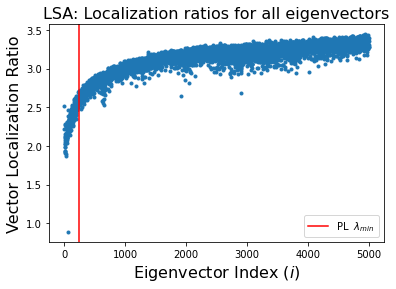

In [14]:
plt.scatter(np.arange(len(loc_ratios)), np.log10(loc_ratios), marker=".", linewidths=1)
plt.axvline(x=istart_tail, color='red', label=r"PL  $\lambda_{min}$")
plt.title("LSA: Localization ratios for all eigenvectors")
plt.xlabel(r"Eigenvector Index $(i)$")
plt.ylabel(r"Vector Localization Ratio")
plt.legend()
if save:
  filename = "LSA_local_ratios.png"
  filename = f"{results_dir}/{filename}"
  print(f"saving {filename}")
  plt.savefig(filename)
              
plt.show()

### Eigenvalues vs fitted PL $\lambda_{min}$

saving /drive/MyDrive/setol_paper/LSA_evals.png


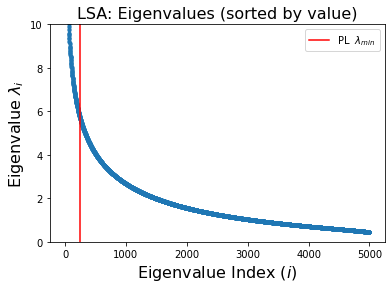

In [15]:
plt.scatter(np.arange(len(loc_ratios)), (evals) , marker='.')
plt.ylim([0,10])
plt.axvline(x=istart_tail, color='red', label=r"PL  $\lambda_{min}$")
plt.xlabel(r"Eigenvalue Index $(i)$")
plt.ylabel(r"Eigenvalue $\lambda_{i}$")
plt.title("LSA: Eigenvalues (sorted by value)")
plt.legend()
if save:
  filename = "LSA_evals.png"
  filename = f"{results_dir}/{filename}"
  print(f"saving {filename}")
  plt.savefig(filename)
plt.show()

### Quality of PL fit on Log-Log Scale, compared to actual data distributions

In [16]:
def plot_logloghist(x, xmin, transparency=0.75):
    hist, bins = np.histogram(x, bins=100)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins, density=True, alpha=transparency)

    if xmin:
        plt.axvline(xmin, color='r', label=r'PL $\lambda_{min}$')

    plt.xscale('log')
    plt.yscale('log')

saving /drive/MyDrive/setol_paper/LSA_PL_fit.png


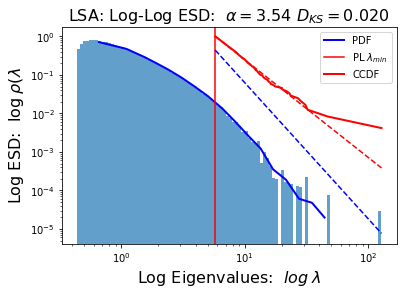

In [17]:
fig2 = fit.plot_pdf(color='b', linewidth=2, original_data=True, label='PDF')
plot_logloghist(evals, fit.xmin,transparency=0.7)

fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
fit.plot_ccdf(color='r', linewidth=2, ax=fig2, label='CCDF')
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=fig2)

title =  "LSA: Log-Log ESD:  "+r"$\alpha=$"+"{:0.2f}".format(fit.alpha) + r" $D_{KS}=$"+"{:0.3f}".format(fit.D)
plt.title(title)
plt.xlabel(r"Log Eigenvalues:  $log\;\lambda$")
plt.ylabel(r"Log ESD:  $\log\;\rho(\lambda}$")
plt.legend()
if save:
  filename = "LSA_PL_fit.png"
  filename = f"{results_dir}/{filename}"
  print(f"saving {filename}")
  plt.savefig(filename)
plt.show()          



### Explained Variance vs fitted PL $\lambda_{min}$

saving /drive/MyDrive/setol_paper/LSA_variance.png


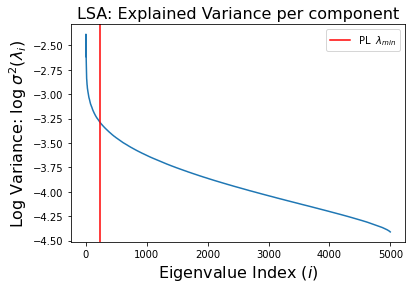

In [18]:
plt.plot(np.arange(5000),np.log10(svd_model.explained_variance_))
plt.title("LSA: Explained Variance per component")
plt.axvline(x=istart_tail, color='red', label=r"PL  $\lambda_{min}$")
plt.xlabel(r"Eigenvalue Index $(i)$")
plt.ylabel(r"Log Variance: $\log\;\sigma^{2}(\lambda_{i})$")
plt.legend()
if save:
  filename = "LSA_variance.png"
  filename = f"{results_dir}/{filename}"
  print(f"saving {filename}")
  plt.savefig(filename)
plt.show()


### Check for Correlation Traps

see: https://stackoverflow.com/questions/12230527/randomly-shuffle-a-sparse-matrix-in-python





In [19]:
W = X.todense()
N, M = W.shape[0], W.shape[1]       

if (N < M):
    N, M = W.shape[1], W.shape[0] 

W_shuf = W.flatten()
np.random.shuffle(W_shuf)
W_shuf = W_shuf.reshape([N, M])

In [20]:
svd_model.fit(W_shuf)
sv = svd_model.singular_values_
rand_evals = sv*sv

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Text(0.5, 1.0, 'LSA ESD vs randomized ESD')

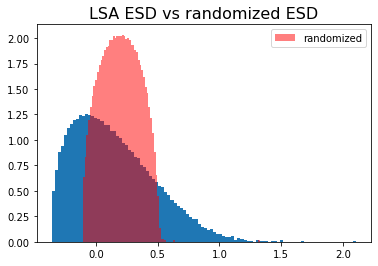

In [21]:
plt.hist(np.log10(evals[evals>0.001]),bins=100, density=True);
plt.hist(np.log10(rand_evals[rand_evals>0.001]),bins=100, density=True, color='red', label='randomized', alpha=0.5);
plt.legend()
plt.title("LSA ESD vs randomized ESD")